In [1]:
%matplotlib inline

# Xin Chen's implementation of the MBE-NN network

* Author: Xin Chen
* Email: Bismarrck@me.com

This jupyter notebook is used to repeat the work of http://doi.org/10.1021/acs.jctc.6b00994. 

The test cluster is $\textrm{C}_{9}\textrm{H}_{7}\textrm{N}$. The reference energies are calculated with DFTB.

<img src="./C9H7N.png" alt="network" style="width: 600px;"/>

## 1. Overview

The structure of the deep convolutional neural network for the $Pt_{13}$ cluster is as follows:

<img src="./convnet.jpg" alt="network" style="width: 800px;"/>

The input features are transformed interatomic distances. The output node represents the estimated DFT energies.
The detailed explanantion of this convolutionary neural network will be given in the following section **Inference**.

## 2. Declarations

In this section we shall import python modules and declare global constants.

In [2]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import re
import h5py
import sys
import time
import hashlib
import shutil
from fnmatch import fnmatch
from itertools import repeat
from os.path import isfile, isdir, join, basename, splitext
from os import makedirs, listdir
from scipy.misc import comb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from itertools import combinations
from matplotlib import pyplot as plt
from IPython.display import clear_output, Image, display, HTML
plt.rcParams["figure.figsize"] = [15, 12]

In [3]:
# The patch size is always 1x1
PATCH_SIZE = 1

# The HDF5 database file.
HDF5_DATABASE_FILE = "c9h7n.hdf5"

# The dimension of the cluster.
NUM_SITES = 17

# The total number of structures in the XYZ file should be 209660.
XYZ_FILE = "../datasets/C9H7N.xyz"
TOTAL_SIZE = 5000

# Setup the size.
LOAD_SIZE = 5000

# Setup the random seed.
SEED = 235

# Setup the precision of floats. 
tf_type = tf.float32
np_type = np.float32

# Cuda
cuda_on = False

The following cell defines the pyykko radii matrix for exponentially scaling interactomic distances. In this $\textrm{C}_{9}\textrm{H}_{7}\textrm{N}$ case, the pyykko bond lengths of C-H, C-N and C-C varys.

In [4]:
factor = 1.5
pyykko_radii = {"N": 0.71, "C": 0.75, "H": 0.32}
species = ["N"] + list(repeat("C", 9)) + list(repeat("H", 7))
rr = np.asarray([pyykko_radii[specie] for specie in species])[:, np.newaxis]
lmat = factor * (rr + rr.T).flatten()

Invoke the interactive session

In [5]:
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)

Some global helper functions are declared here.

In [6]:
def brange(start, stop, batchsize):
  """
  Range from `start` to `stop` given a batch size and return the start and stop of each batch.
  
  Args:
    start: int, the start number of a sequence.
    stop: int, the end number of a sequence.
    batchsize: int, the size of each batch.
  
  """
  istart = start
  while istart < stop:
    istop = min(istart + batchsize, stop)
    yield istart, istop
    istart = istop


def exponential(x, l=4.0):
  """
  Exponentially scale the input value(s).  
  """
  return np.exp(-x / l)


def md5(filename):
  """ 
  Return the md5 checksum of the given file.

  Args:
    filename: a file.

  Returns:
    checksum: the MD5 checksum of the file.

  """
  hash_md5 = hashlib.md5()
  with open(filename, "rb") as f:
    for chunk in iter(lambda: f.read(4096), b""):
      hash_md5.update(chunk)
  return hash_md5.hexdigest()


def root_mean_squred(x):
  """
  Return the root mean squared of the given array.
  """
  return np.sqrt(np.mean(np.square(x)))


def mean_abs_error(y_true, y_pred):
  """
  Return the mean absolute error.
  """
  return np.mean(np.abs(y_true - y_pred))

## 3. Inference

This convnet is a slightly different from normal convolutionary neural networks. Suppose N is the batch size:

* The shape of the input tensor is: $[N, 1, C_{N}^{k}, C_{k}^{2}]$
* The **k** defines the many-body expansion. In this paper, k is selected to be 4.
* The patch (kernel) is always 1x1.
* The padding scheme is 'SAME' and the strides are 1 in both directions.
* A shape transpose action should be taken between layer 4 and 5.


In this section we define some local helper functions.

In [7]:
def variable_summaries(tensor):
  """
  Attach a lot of summaries to a Tensor (for TensorBoard visualization).

  Args:
    tensor: a Tensor.

  """
  with tf.name_scope('summaries'):
    mean = tf.reduce_mean(tensor)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(tensor, mean))))
      tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(tensor))
    tf.summary.scalar('min', tf.reduce_min(tensor))
    tf.summary.histogram('histogram', tensor)

    
def print_activations(t):
  """
  Print the name and shape of the input Tensor.

  Args:
    t: a Tensor.

  """
  print("%-21s : %s" % (t.op.name, t.get_shape().as_list()))

All layers except the last in this MBE-NN network are convolutionary layers. The activation functions are ``tanh`` and ``softplus`` and there is no pooling operation before the output layer. So this function is used to create the conv2d layers of this network.

In [8]:
def mbe_conv2d(tensor, n_in, n_out, name, activate=tf.tanh, params_track=None, verbose=True):
  """ A lazy inner function to create a `tf.nn.conv2d` Tensor.

  Args:
    tensor: a Tensor, [index, 1, w, n_in]
    n_in: the number of input channels.
    n_out: the number of output channels.
    name: the name of this layer.
    activate: the activation function, defaults to `tf.tanh`.
    params_track: append the kernel and the bias into this list if not None.
    verbose: print the layer if True

  Returns:
    activated: a Tensor of activated `tf.nn.conv2d`.

  """
  with tf.name_scope(name):
    with tf.name_scope("filter"):
      kernel = tf.Variable(
        tf.truncated_normal(
          [1, 1, n_in, n_out], stddev=0.1, seed=SEED, dtype=tf_type), 
        name="kernel")
      variable_summaries(kernel)
    conv = tf.nn.conv2d(
      tensor, kernel, [1, 1, 1, 1], padding="SAME", use_cudnn_on_gpu=cuda_on)
    with tf.name_scope("biases"):
      biases = tf.Variable(
        tf.zeros([n_out], dtype=tf_type), name="biases")
      variable_summaries(biases)
    bias = tf.nn.bias_add(conv, biases)
    activated = activate(bias)
    if isinstance(params_track, list):
      params_track.extend([kernel, biases])
    if verbose:
      print_activations(activated)
  return activated

Now we can infer the MBE-NN neural network. 

In [9]:
def inference(dataset, cnk, verbose=True):
  """
  Return the infered MBE-NN-M deep neural network model.

  Args:
    dataset: a 4D dataset Tensor as the input layer, [batch, 1, C(N,k), C(k,2)]
    cnk: the value of C(N,k), an int.
    verbose: print layer details if True.

  Returns:
    pool: the last Tensor of `tf.nn.avg_pool`, [batch, 1, 1, 1]

  References:
    Alexandrova, A. N. (2016). http://doi.org/10.1021/acs.jctc.6b00994

  """
  if verbose:
    print("-> Inference the MBE-NN-M model ...")
    print("")

  parameters = []

  # Build the first three MBE layers.
  # The shape of the input data tensor is [n, 1, C(N,k), C(k,2)].
  # To fit Fk, the NN connection is localized in the second dimension, and the
  # layer size of the first dimension is kept fixed. The weights and biases of
  # NN connection are shared among different indices of the first dimension,
  # so that the fitted function form of Fk is kept consistent among different
  # k-body terms. The MBE part is composed of four layers with the following
  # sizes:
  # (C(N,k), C(k,2)) - (C(N,k), 40) - (C(N,k), 70) - (C(N,k), 60) - (C(N,k), 2).
  conv1 = mbe_conv2d(dataset, 6,  48, "Conv1", activate=tf.nn.tanh)
  conv2 = mbe_conv2d(conv1,  48,  96, "Conv2", activate=tf.nn.tanh)
  conv3 = mbe_conv2d(conv2,  96,  60, "Conv3", activate=tf.nn.tanh)

  # Then we build the three mixing layers.
  # The mixing part is used to fit G. Within this part the NN connection is
  # localized in the first dimension, and the size of the second dimension is
  # kept fixed. The parameters of NN connection in this part are shared among
  # different indices of the second dimension. In this work, the mixing part is
  # composed of two layers with the following sizes:
  # (C(N, k), 2) - (40, 2) - (10, 2).
  conv4 = mbe_conv2d(conv3, 60, 2, "Conv4", activate=tf.nn.softplus)
  conv5 = mbe_conv2d(tf.reshape(conv4, (-1, 1, 2, cnk)),
                     cnk, 100, "Conv5", activate=tf.nn.softplus)
  conv6 = mbe_conv2d(conv5, 100, 20, "Conv6", activate=tf.nn.softplus)

  # The last part is used to transform the output of mixing part to a single
  # value, representing the energy. The average-pooling is used, which means
  # that we take the average value of all elements in the matrix of the previous
  # layer as the final output. In this work, the pooling part is composed of one
  # layer of the size:
  # (10, 2) - (1).
  with tf.name_scope("Pool7"):
    pool7 = tf.nn.avg_pool(tf.reshape(conv6, [-1, 20, 2, 1]),
                           ksize=[1, 20, 2, 1],
                           strides=[1, 1, 1, 1],
                           padding="VALID")
    if verbose:
      print_activations(pool7)
      print("")

  return tf.reshape(pool7, (-1, 1)), parameters

## 4. Preparing the Dataset

### 4.1 Transformation

It is known that Gaussian coordinates are not suitable to direcly used as input of NN. Therefor, two transformations are adapted here on the input sample data in Cartesian coordiantes $\{r_{j}\}$:

1. Transform each set of combination indices $\{j\}$ ($k=4$) to interatomic distances $\{d_{i,j}\}$ ($C_{k}^{2}=6$). 
2. Dump these interatomic distances with the exponential function: $d_{i,j}' = e^{-d_{i,j}/L}$. $L$ is a fixed parameter and 4.0 was used in this paper.

The following figure demonstrates the workflow of these transformations:

<img src="./input_transform.png" alt="Drawing" style="width: 900px;"/>

The shape of the final input matrix should be: [1, $C_{N}^{k}$, $C_{k}^{2}$]

* The width is 1
* The height is $C_{N}^{k}$
* The depth is $C_{k}^{2}$

So that we can use it in a convolutionary neural network!

In [10]:
def transform_coords(coords, chunksize, mapping, l=4.0, verbose=True):
  """
  Transform the cartesian coordinates to input features.

  Args:
    coords: a 3D array with shape [M,N,3] representing the cartesian coordinates.
    chunksize: the transformed array is too large. So save it piece by piece.
    mapping: a `h5py.Dataset`, which is a symbolic to the real data on disk.
    l: the exponential parameter.
    verbose: print the transformation progress if True.

  """
  ntotal, n = coords.shape[:2]
  cnkv = comb(n, 4, exact=True)
  ck2v = comb(4, 2, exact=True)
  cnkl = list(combinations(range(NUM_SITES), 4))
  # Using mapping indices can increase the speed 30 times!
  indices = np.zeros((ck2v, cnkv), dtype=int)
  for i in range(cnkv):
    for j, (vi, vj) in enumerate(combinations(cnkl[i], 2)):
      indices[j, i] = vi * n + vj
  dataset = np.zeros((chunksize, 1, cnkv, ck2v), dtype=np_type)
  tic = time.time()
  if verbose:
    print("Transform the cartesian coordinates ...\n")
  for i, inext in brange(0, ntotal, chunksize):
    for j in range(i, inext):
      dists = pairwise_distances(coords[j]).flatten()
      dists = exponential(dists, l=l)
      for k in range(ck2v):
        dataset[j - i, 0, :, k] = dists[indices[k]]
      del dists
    batch_size = inext - i
    mapping[i: inext, ...] = dataset[:batch_size, ...]
    if verbose:
      sys.stdout.write("\rProgress: %7d  /  %7d" % (inext, ntotal))
    dataset.fill(0.0)
  del indices
  del dataset
  if verbose:
    print("")
    print("Total time: %.3f s\n" % (time.time() - tic))

### 4.2 Extract

Extract the XYZ coordinates and atomic symbols from the raw file. The raw file is not a standard XYZ file, so we need to write a helper function to do this.

In [11]:
def extract_xyz(filename, verbose=True):
  """
  Extract symbols, coordiantes and forces (for later usage) from the raw file.
  
  Args:
    filename: a str.
    verbose: a bool.

  Returns
    energies: Array[N,]
    coordinates: Array[N, 17, 3], a 3D array containing the atomic coordinates.
    forces: Array[N, 17, 3], a 3D array containing the atomic forces.
  
  """
  group = "raw"
  hdb = h5py.File(HDF5_DATABASE_FILE)
  if group not in hdb:
    hdb.create_group(group)
  
  try:
    energies = hdb[group]["energies"][:]
    coordinates = hdb[group]["coordinates"][:]
    forces = hdb[group]["forces"][:]

  except Exception:
    energies = np.zeros((TOTAL_SIZE,), dtype=np_type)
    coordinates = np.zeros((TOTAL_SIZE, NUM_SITES, 3), dtype=np_type)
    forces = np.zeros((TOTAL_SIZE, NUM_SITES, 3), dtype=np_type)
    stage = 0
    i = 0
    j = 0
    energy_patt = re.compile(r".*energy=([\d.-]+).*")
    string_patt = re.compile(r"([A-Za-z]{1,2})\s+([\d.-]+)\s+([\d.-]+)\s+([\d.-]+)\s+"
                              "\d+\s+\d.\d+\s+\d+\s+([\d.-]+)\s+([\d.-]+)\s+([\d.-]+)")
    tic = time.time()
    if verbose:
      sys.stdout.write("Extract cartesian coordinates ...\n")
    with open(filename) as f:
      for line in f:
        if i == TOTAL_SIZE:
          break
        l = line.strip()
        if l == "":
          continue
        if stage == 0:
          if l.isdigit():
            n = int(l)
            if n != NUM_SITES:
              raise ValueError("The parsed size %d != NUM_SITES" % n)
            stage += 1
        elif stage == 1:
          m = energy_patt.search(l)
          if m:
            energies[i] = float(m.group(1))
            stage += 1
        elif stage == 2:
          m = string_patt.search(l)
          if m:
            coordinates[i, j, :] = float(m.group(2)), float(m.group(3)), float(m.group(4))
            forces[i, j, :] = float(m.group(5)), float(m.group(6)), float(m.group(7))
            j += 1
            if j == NUM_SITES:
              j = 0
              stage = 0
              i += 1
              if verbose and i % 1000 == 0:
                sys.stdout.write("\rProgress: %7d  /  %7d" % (i, TOTAL_SIZE))
      if verbose:
        print("")
        print("Total time: %.3f s\n" % (time.time() - tic))
      hdb[group].create_dataset("energies", data=energies)
      hdb[group].create_dataset("coordinates", data=coordinates)
      hdb[group].create_dataset("forces", data=forces)
  
  finally:
    hdb.close()
  
  return energies, coordinates, forces

Extract cartesian coordinates ...
Progress:    5000  /     5000
Total time: 0.740 s



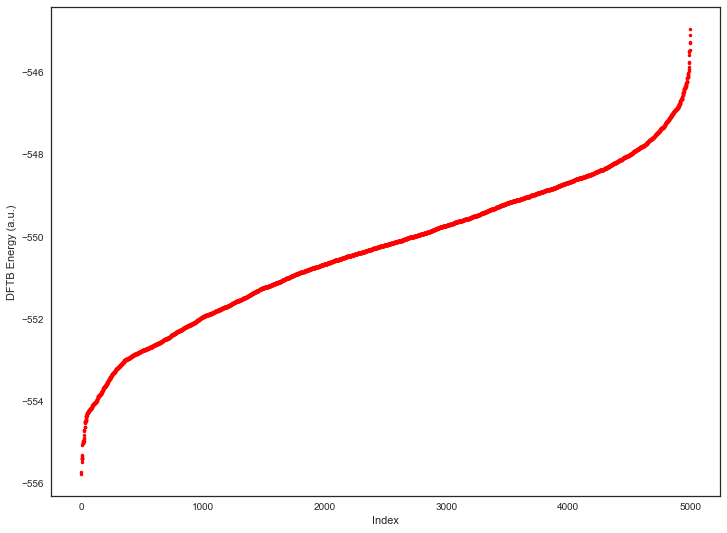

In [12]:
plt.rcParams["figure.figsize"] = [12, 9]
energies, coordinates, _ = extract_xyz(XYZ_FILE)
sns.set_style("white")
plt.xlabel("Index")
plt.ylabel("DFTB Energy (a.u.)")
plt.plot(energies, 'r.')

### 4.3 Build

Build the dataset and split it into training, validation and testing datasets:

1. Initialize a new hdf5 file if it can not be accessed.
1. Extract symbols, energies, atomic coordinates and forces from the file.
2. Transform and scale the coordinates to build the 4D array $[N, 1, C_{N}^{k}, C_{k}^{2}]$.

**Warning: in this case ($\textrm{C}_{9}\textrm{H}_{7}\textrm{N}$), all samples are considered unique!**

In [13]:
def may_build_dataset(filename, l=4.0, verbose=True):
  """
  Build the training, validation and testing dataset and targets from a XYZ file.

  Args:
    filename: str, a file with CP2K/XYZ format.
    l: float, the exponential parameter.
    verbose: bool, print the building progress if True.

  Returns:
    features: a 4D array as the transformed input features.
    targets: a 2D array as the scaled ([0, 1]) targets.
    scaler: a ``sklearn.preprocessing.MinMaxScaler``.

  """
  # Compute the MD5 checksum of the xyzfile
  checksum = md5(filename)

  if verbose:
    print("-> Load the training, validation and testing datasets ...\n")

  coords, energies = None, None
  features, targets = None, None
  backup_hdf5 = False
  extract_coords = True
  build_features = True

  # If the HDF5 file is already existed, we try to load dataset and targets from
  # the HDF5 file directly if the checksums are equal.
  if isfile(HDF5_DATABASE_FILE):
    with h5py.File(HDF5_DATABASE_FILE, "r") as hdb:
      if hdb.attrs.get("checksum", 0) == checksum:
        # There are two main groups in this HDF5 file:
        # 1. the first group is 'train' where training data and training targets
        # are stored.
        if "train" in hdb:
          features = hdb["train"]["dataset"][:LOAD_SIZE]
          targets = hdb["train"]["targets"][:LOAD_SIZE]
          build_features = False
          extract_coords = False
        # 2. the second group is 'unique' where uniquified cartesian coordinates
        # and their energies extracted from a CP2K/XYZ file are saved.
        elif "unique" in hdb.keys():
          coords = hdb["unique"]["coords"][:]
          energies = hdb["unique"]["energies"][:]
          extract_coords = False
      # The checksum are not equal, so we backup the existed HDF5 databse by
      # renaming it.
      else:
        backup_hdf5 = True
    if backup_hdf5:
      if verbose:
        print("MD5 checksums mismatched. Build a new dataset.\n")
      shutil.move(HDF5_DATABASE_FILE, HDF5_DATABASE_FILE + ".bak")

  # Extract the raw cartesian coordinates and energis (eV) from the CP2K/XYZ
  # file and save these data into group 'raw'. All data are compressed with the
  # lossless gzip filter.
  if extract_coords:
    energies, coords, _ = extract_xyz(filename, verbose=verbose)
    # Remove the duplicates to reduce the dataset
    # coords, energies = remove_duplicates(coords, energies, verbose=verbose)
    with h5py.File(HDF5_DATABASE_FILE) as hdb:
      # Delete the previous group `unique`. This should not happen, but it may
      # be inserted manually for debugging.
      group = "unique"
      if group in hdb.keys():
        del hdb[group]
      hdb.attrs["checksum"] = checksum
      hdb.create_group(group)
      hdb[group].create_dataset("coords", data=coords, compression="gzip")
      hdb[group].create_dataset("energies", data=energies, compression="gzip")
  elif verbose:
    print("Use existed coordinates and energies.\n")

  # Transform the cartesian coordinates to a 4D dataset. Permute this dataset
  # several times and then we split it into three parts: training, validation
  # and testing. Save these datasets and their targets into group 'cnn'.
  if build_features:
    # Allocate the disk space and then write transformed data piece by piece
    # because my little computer only has 16GB memory.
    shape = [len(energies), 1, comb(NUM_SITES, 4, True), comb(4, 2, True)]
    hdb = h5py.File(HDF5_DATABASE_FILE)
    try:
      group = hdb.require_group("train")
      group.create_dataset("targets", data=energies)
      mapping = group.create_dataset(
        "dataset", shape=shape, dtype=np.float32)
      # Set the chunksize to 10000.
      chunksize = 10000
      transform_coords(coords, chunksize, mapping, l=l, verbose=verbose)
    except Exception as excp:
      del hdb["train"]
      raise excp
    finally:
      hdb.close()
    # After the transformation we now load the whole dataset into memory.
    with h5py.File(HDF5_DATABASE_FILE) as hdb:
      features = hdb["train"]["dataset"][:LOAD_SIZE]
      targets = np.array(energies[:LOAD_SIZE], copy=False)
    if verbose:
      print("Dataset size (MB)     : ", features.nbytes / 1024 / 1024)
      print("Targets size (MB)     : ", targets.nbytes / 1024 / 1024)
      print("")
    del coords
  elif verbose:
    print("Use existed features and targets.\n")

  # Determine the maximum and minimum energy. The energies should be scaled to
  # [0, 1] during training.
  scaler = MinMaxScaler()
  targets = scaler.fit_transform(np.atleast_2d(targets).T)

  if verbose:
    print("-> Datasets and targets are loaded into memories.")
    print("")
  return features, targets, scaler

In [14]:
features, targets, scaler = may_build_dataset(XYZ_FILE, l=lmat)

-> Load the training, validation and testing datasets ...

MD5 checksums mismatched. Build a new dataset.

Extract cartesian coordinates ...
Progress:    5000  /     5000
Total time: 0.731 s

Transform the cartesian coordinates ...

Progress:    5000  /     5000
Total time: 1.606 s

Dataset size (MB)     :  272.369384765625
Targets size (MB)     :  0.019073486328125

-> Datasets and targets are loaded into memories.



### 4.4 The Distribution

The following figure demonstrates the distribution of all values in the dataset.

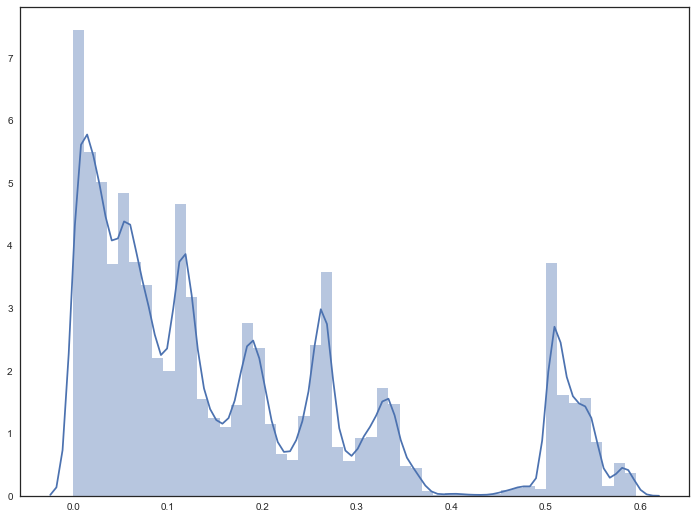

In [15]:
sns.set_style("white")
sns.distplot(features.flatten()[::20])

## 5. Training

Now we can start training this network. The training settings defined in this paper are summerized here:

* Root-mean-squared loss.
* Mini-batch stochastic gradient descent with momentum
     * Batch size: 50.
     * Momentum factor: 0.7.
* Step Decay Function: $s_{i} = s_{0}r/(r + i)$
     * $s_0$ is the initial step length, which is 0.1 in this paper.
     * r is a predefined factor and r = 60 in this paper.
* Regularization factor is not mentioned in this paper.
     * $\lambda$ is set to None.
* The exponentia ldecay rate is 0.9 in this implementaion.
* The total number of epochs for the reference dataset is 1400.

These parameters are declared in the following section:

In [16]:
batch_size = 50
momentum_factor = 0.7
start_learning_rate = 0.1
decay_rate = 0.9
rlambda = None

### 5.1 Setup

Before we start training, the dataset should be splited. ``sklearn.model_selection.train_test_split`` can be used to achieve this. Remember to set the random state!

In [17]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, random_state=SEED, test_size=0.1)

Now we can begin the training. Initialize a new ``graph`` and use it as the default graph. Then we get the infered network.

In [18]:
width = 1
height = comb(NUM_SITES, 4, exact=True)
depth = 6

X_batch = tf.placeholder(tf_type, [batch_size, width, height, depth])
y_batch = tf.placeholder(tf_type, [batch_size, 1])

estimates, parameters = inference(X_batch, height)

-> Inference the MBE-NN-M model ...

Conv1/Tanh            : [50, 1, 2380, 48]
Conv2/Tanh            : [50, 1, 2380, 96]
Conv3/Tanh            : [50, 1, 2380, 60]
Conv4/Softplus        : [50, 1, 2380, 2]
Conv5/Softplus        : [50, 1, 2, 100]
Conv6/Softplus        : [50, 1, 2, 20]
Pool7/AvgPool         : [50, 1, 1, 1]



Add helper functions to visualize the graph. These codes are copied from the official example **deepdream**. Uncomment the last line can display the network graph inline.

In [19]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script src="//cdnjs.cloudflare.com/ajax/libs/polymer/0.3.3/platform.js"></script>
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Uncomment the following line to visualize the graph in this notebook. 
# show_graph(graph.as_graph_def())

Setup the total loss.

In [20]:
with tf.name_scope("loss"):
  rms = tf.sqrt(tf.losses.mean_squared_error(estimates, y_batch))
  tf.summary.scalar("rms", rms)
  if rlambda is not None:
    with tf.name_scope("regularizers"):
      r = rlambda * tf.nn.l2_loss(parameters[0])
      for params in parameters:
        r += rlambda * tf.nn.l2_loss(params)
      tf.summary.scalar("regularizer", r)
    loss = rms + r
    tf.summary.scalar("loss", loss)
  else:
    loss = rms

Setup the learning rate decay and the momentum optimizer.

In [21]:
batch = tf.Variable(0, dtype=tf.int64)
learning_rate = tf.train.exponential_decay(
  start_learning_rate, 
  tf.multiply(batch, batch_size), 
  len(X_train), 
  decay_rate,
)

# Test the Adagrad optimzier
# trainer = tf.train.AdagradDAOptimizer(
#   learning_rate=learning_rate, 
#   initial_gradient_squared_accumulator_value=0.1,
#   global_step=batch
# )

# Use the Momentum optimizer
trainer = tf.train.MomentumOptimizer(learning_rate, momentum_factor)
optimizer = trainer.minimize(loss, global_step=batch)

# Merge all the summaries.
merged = tf.summary.merge_all()
writer = tf.summary.FileWriter(logdir="./events", graph=graph)

### 5.2 Train

These variabls control the key settings of a training.

In [22]:
num_epochs = 200
log_frequency = 100
eval_frequency = 500
save_frequency = 1000

Setup the saving path and the checkpoint file so that we can reuse this model later.

In [23]:
save_path = "./saves"
chk_file = join(save_path, "c9h7n.ckpt")
if not isdir(save_path):
  makedirs(save_path)

Small utility function to evaluate a dataset by feeding batches of data to ``{eval_dataset}`` and pulling the results 
from ``{eval_values}``. Saves memory and enables this to run on smaller GPUs.

In [24]:
def eval_in_batches(data):
  """ Get all predictions for a dataset by running it in small batches. """
  size = data.shape[0]
  if size < batch_size:
    raise ValueError("batch size for evals larger than dataset: %d" % size)
  eval_values = np.ndarray(shape=(size, 1), dtype=np_type)
  for i, inext in brange(0, size, batch_size):
    eval_values[i: inext] = sess.run(
      estimates,
      feed_dict={X_batch: data[i: inext, ...]})
  return eval_values

This helper function is used to restore the latest checkpoint if existed.

In [25]:
def restore_latest_from_ckpt(save_dir, chk):
  """
  Restore the latest checkpoint from the 'scratch' if possible.
  """
  if not isdir(save_dir):
    return None
  cpkt_patt = "%s*" % basename(chk)
  files = []
  for afile in listdir(save_dir):
    if fnmatch(afile, cpkt_patt):
      files.append(afile)
  if len(files) == 0:
    return None
  files.sort(reverse=True)
  return join(save_dir, splitext(files[0])[0])

Finally we invoke a new session and start this training.

In [ ]:
# Build an initialization operation.
tf.global_variables_initializer().run()

# Register a model saver
saver = tf.train.Saver()

# Load the previous checkpoint if existed.
prev_cpkt = restore_latest_from_ckpt(save_path, chk_file)
if prev_cpkt:
  saver.restore(sess, prev_cpkt)
  print("Restore from the lastest checkpoint file %s ..." % prev_cpkt)
  print("")

print("Initialized!")
print("")
print("Training Samples      :", len(X_train))
print("Batch Size            :", batch_size)
print("Number of Epochs      :", num_epochs)
print("Log Frequency         :", log_frequency)
print("Eval Frequency        :", eval_frequency)
print("")

tic = time.time()
tstart = time.time()

# Loop through training steps.
for step in range(int(num_epochs * len(X_train)) // batch_size):
  # Compute the offset of the current minibatch in the data.
  # The dataset was already shuffled in assignment 1 so we do not need to
  # randomize it.
  offset = (step * batch_size) % (len(X_train) - batch_size)
  batch_dataset = X_train[offset: (offset + batch_size), ...]
  batch_targets = y_train[offset: (offset + batch_size), ...]
  # Build the feed dict to feed previous defined placeholders.
  feed_dict = {X_batch: batch_dataset, y_batch: batch_targets}
  # Run the optimization session.
  sess.run([optimizer], feed_dict=feed_dict)
  # Save the training accuracy every 100 steps.
  if step % log_frequency == 0:
    summary, error = sess.run([merged, loss], feed_dict=feed_dict)
    elapsed_time = time.time() - tic
    tic = time.time()
    print("Step %6d (epoch %5.2f)" % (
      step, float(step) * batch_size / len(X_train)))
    print("Minibatch loss        : %.6f" % error)
    print("Minibatch time        : %.3f s" % elapsed_time)
    writer.add_summary(summary, step)
    # Every `eval_frequency` steps we shall take several extra operations,
    # including printing the validation accuracy and updating the learning
    # rate.
    if step % eval_frequency == 0:
      lr = sess.run(learning_rate)
      valid_error = root_mean_squred(y_test - eval_in_batches(X_test))
      print("Validation error      : %.6f" % valid_error)
      print("learning rate         : %.6f" % lr)
      print("Time since beginning  : %.3f s" % (time.time() - tstart))
      print("")
    sys.stdout.flush()
  # Save the trained model every 1000 steps.
  if step % save_frequency == 0:
    saver.save(sess, save_path=chk_file, global_step=batch)
# Close the writer
writer.close()
# Finally the training is completed. Now let me see if this MBE model can
# really estimate DFT energies.
print("")
print("-> Test error         : %.6f" % root_mean_squred(y_test - eval_in_batches(X_test)))
print("")
# Do not forget to save the model one last time!
saver.save(sess, save_path=chk_file, global_step=batch)

### 5.3 Figures

In this section we will display some figures to analyze the results.

In [ ]:
y_train_est = eval_in_batches(X_train)
train_orders = np.argsort(y_train.flatten())

y_test_est = eval_in_batches(X_test)
test_orders = np.argsort(y_test.flatten())

In [ ]:
plt.rcParams["figure.figsize"] = [15, 12]

sns.set_style("white")
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(y_train[train_orders], "r.")
ax1.plot(y_train_est[train_orders], "g.")
ax1.set_ylabel("Scaled Energy (eV)", fontsize=15)
ax1.set_title("Training Data", fontsize=18)

ax2.plot(y_test[test_orders], "r.")
ax2.plot(y_test_est[test_orders], "g.")
ax2.set_xlabel("Atomic Index", fontsize=15)
ax2.set_ylabel("Scaled Energy (eV)", fontsize=15)
ax2.set_title("Testing Data", fontsize=18)